# CV를 위한 전이학습

전이학습 방법은 아래의 두 가지가 존재  
  
1. 합성곱 신경망의 미세조정: 학습된 모델 불러온 뒤, 가지고 있는 데이터셋에 다시 학습 시키기. 기존에 학습이 이미 되어있어서 feature를 잘 뽑는 와중 새로운 데이터의 feature를 찾아가는 것  
2. 인코더 고정 후, 미세조정: 학습된 모델을 불러온 뒤, 이 부분의 파라미터는 모두 고정. 그 이후, 추가한 레이어의 파라미터만 조정하는 것

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

c:\Users\dmqa\anaconda3\envs\main\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
data_transform = {
    'train': transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
         ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/hymenoptera_data/'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transform[x]) 
                 for x in ['train', 'val']}

dataloader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=4, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val']}
class_name = image_dataset['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

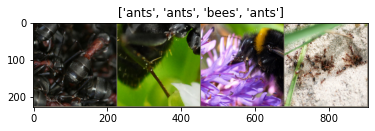

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloader['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_name[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch} / {num_epochs - 1}')
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}' )
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model

In [19]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_name[pred[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(model=was_training)

## 합성곱 신경망 미세조정

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\dmqa/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.5MB/s]


In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0 / 24
----------
train Loss: 0.5974 Acc: 0.6885
val Loss: 0.3336 Acc: 0.8824

Epoch 1 / 24
----------
train Loss: 0.6534 Acc: 0.7582
val Loss: 0.4076 Acc: 0.8235

Epoch 2 / 24
----------
train Loss: 0.3971 Acc: 0.8607
val Loss: 0.3826 Acc: 0.8431

Epoch 3 / 24
----------
train Loss: 0.7589 Acc: 0.7828
val Loss: 0.5265 Acc: 0.8170

Epoch 4 / 24
----------
train Loss: 0.5435 Acc: 0.7951
val Loss: 0.3563 Acc: 0.8627

Epoch 5 / 24
----------
train Loss: 0.5025 Acc: 0.8074
val Loss: 0.4822 Acc: 0.8301

Epoch 6 / 24
----------
train Loss: 0.5028 Acc: 0.8115
val Loss: 0.2835 Acc: 0.9085

Epoch 7 / 24
----------
train Loss: 0.3058 Acc: 0.8607
val Loss: 0.2204 Acc: 0.9150

Epoch 8 / 24
----------
train Loss: 0.3738 Acc: 0.8566
val Loss: 0.2221 Acc: 0.9150

Epoch 9 / 24
----------
train Loss: 0.3343 Acc: 0.8566
val Loss: 0.1950 Acc: 0.9477

Epoch 10 / 24
----------
train Loss: 0.2781 Acc: 0.8730
val Loss: 0.1868 Acc: 0.9346

Epoch 11 / 24
----------
train Loss: 0.2117 Acc: 0.9221
val Loss

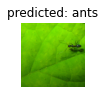

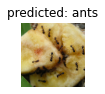

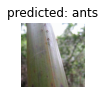

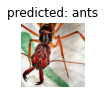

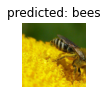

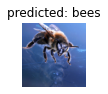

In [20]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망

In [21]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0 / 24
----------
train Loss: 0.6189 Acc: 0.6762
val Loss: 0.2845 Acc: 0.8889

Epoch 1 / 24
----------
train Loss: 0.4359 Acc: 0.7705
val Loss: 0.2661 Acc: 0.8954

Epoch 2 / 24
----------
train Loss: 0.5667 Acc: 0.7623
val Loss: 0.2397 Acc: 0.9150

Epoch 3 / 24
----------
train Loss: 0.4052 Acc: 0.8197
val Loss: 0.3332 Acc: 0.8758

Epoch 4 / 24
----------
train Loss: 0.6409 Acc: 0.7418
val Loss: 0.3313 Acc: 0.8758

Epoch 5 / 24
----------
train Loss: 0.3882 Acc: 0.8279
val Loss: 0.3325 Acc: 0.8627

Epoch 6 / 24
----------
train Loss: 0.4643 Acc: 0.8074
val Loss: 0.1665 Acc: 0.9412

Epoch 7 / 24
----------
train Loss: 0.2996 Acc: 0.8689
val Loss: 0.1518 Acc: 0.9542

Epoch 8 / 24
----------
train Loss: 0.2988 Acc: 0.8689
val Loss: 0.1847 Acc: 0.9542

Epoch 9 / 24
----------
train Loss: 0.3630 Acc: 0.8443
val Loss: 0.1966 Acc: 0.9477

Epoch 10 / 24
----------
train Loss: 0.2574 Acc: 0.8730
val Loss: 0.1888 Acc: 0.9542

Epoch 11 / 24
----------
train Loss: 0.2942 Acc: 0.8893
val Loss

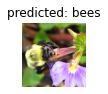

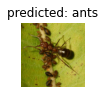

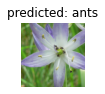

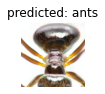

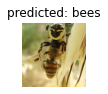

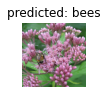

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()